## **Importing Libraries**

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import keras
import os
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

In [127]:
# Load metadata
metadata = pd.read_excel("D:\\My_Acad\\VS_Code\\Sem_6_code\\DL\\project\\kishore_code\\VQA_RAD Dataset Public.xlsx")

In [128]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   QID_unique    2248 non-null   int64 
 1   QID_para      2248 non-null   object
 2   QID_linked    2248 non-null   object
 3   IMAGEID_case  2248 non-null   object
 4   IMAGEID       2248 non-null   object
 5   IMAGEORGAN    2248 non-null   object
 6   EVALUATION    2248 non-null   object
 7   QUESTION      2248 non-null   object
 8   Q_REPHASE     1776 non-null   object
 9   Q_RELATION    1487 non-null   object
 10  Q_FRAMED      1267 non-null   object
 11  Q_TYPE        2248 non-null   object
 12  ANSWER        2247 non-null   object
 13  A_TYPE        2248 non-null   object
dtypes: int64(1), object(13)
memory usage: 246.0+ KB


In [129]:
metadata["Q_TYPE"].value_counts()

Q_TYPE
PRES            800
POS             316
ABN             202
OTHER           194
MODALITY        185
SIZE            171
PLANE           120
ATTRIB           87
ORGAN            59
COLOR            52
COUNT            24
POS, PRES         6
PRES, ATTRIB      6
PRES, POS         4
ATTRIB, PRES      4
ABN, POS          3
SIZE, PRES        2
Other             2
COLOR, PRES       2
POS, ABN          2
SIZE, COLOR       2
ATTRIB, SIZE      1
PRES, ABN         1
PRES, COLOR       1
ATRIB             1
PRSE              1
Name: count, dtype: int64

In [130]:
metadata.isna().sum()

QID_unique        0
QID_para          0
QID_linked        0
IMAGEID_case      0
IMAGEID           0
IMAGEORGAN        0
EVALUATION        0
QUESTION          0
Q_REPHASE       472
Q_RELATION      761
Q_FRAMED        981
Q_TYPE            0
ANSWER            1
A_TYPE            0
dtype: int64

In [131]:
metadata["A_TYPE"].value_counts()

A_TYPE
CLOSED     1297
OPEN        949
CLOSED        2
Name: count, dtype: int64

In [132]:
metadata["ANSWER"].value_counts()[:20]

ANSWER
No                                      486
Yes                                     347
yes                                     239
no                                      120
Axial                                    28
Right                                    22
Left                                     18
PA                                       15
axial                                    15
CT                                       13
Brain                                    10
MRI                                       8
Right side                                8
fat                                       7
Right upper lobe                          7
Right lung                                7
5.6cm focal, predominantly hypodense      6
Bilateral                                 6
Diffuse                                   6
Left kidney                               6
Name: count, dtype: int64

<Axes: xlabel='IMAGEORGAN'>

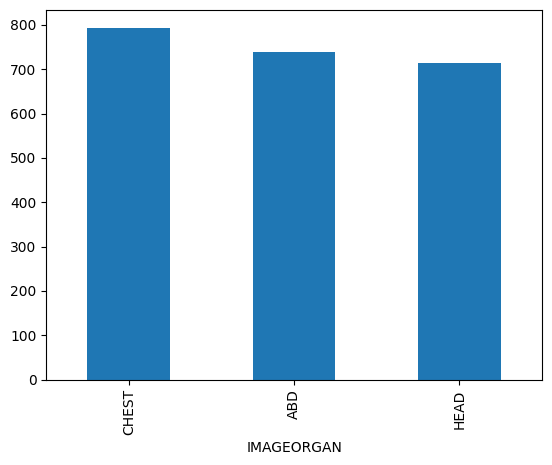

In [133]:
metadata["IMAGEORGAN"].value_counts().plot.bar()

In [134]:
# Filter metadata to include only entries with A_TYPE as "CLOSED"
metadata = metadata[metadata["A_TYPE"] == "CLOSED"]

In [135]:
# Further filter metadata to include only entries with "yes" and "no" answers
sampledata = metadata[(metadata["ANSWER"].str.lower() == "yes") | (metadata["ANSWER"].str.lower() == "no")]
sampledata.reset_index(inplace=True, drop=True)

In [136]:
# Convert answers to binary labels
labels = sampledata["ANSWER"].str.lower().map({'yes': 1, 'no': 0}).values
print(labels)

[1 0 0 ... 1 1 1]


## **Tokenizing**

In [137]:
# Tokenize questions
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

docx = sampledata["QUESTION"].tolist()
tokenizer = Tokenizer(oov_token="<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding="post", maxlen=10)

In [138]:
print(sequences)

[[  9 478   8 ...   0   0   0]
 [  9   3  49 ...   0   0   0]
 [  2   4  15 ...   0   0   0]
 ...
 [  2   4 458 ...   0   0   0]
 [  2   5   7 ...   0   0   0]
 [  2   5  82 ... 204   0   0]]


In [139]:
# Prepare image addresses
IMGDIR = "D:\\My_Acad\\VS_Code\\Sem_6_code\\DL\\project\\kishore_code\\VQA_RAD Image Folder\\"
addresses = [IMGDIR + img_id.split('/')[-1] for img_id in sampledata["IMAGEID"]]

In [140]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
train_addresses, val_addresses, ytrain, ytest = train_test_split(addresses, labels, test_size=0.2, random_state=42)
train_sequences, val_sequences, ytrain, ytest = train_test_split(sequences, labels, test_size=0.2, random_state=42)

## **Data Augmentation and Processing**

In [141]:

# Data augmentation and processing functions
def augment_data(tup, label):
    image, sequence = tup
    angle = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(angle / 90, dtype=tf.int32))
    shift_x = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    shift_y = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    image = tf.roll(image, shift_x, axis=1)
    image = tf.roll(image, shift_y, axis=0)
    return (image, sequence), label

def process_data(image_path, text_sequence, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image / 255.0, dtype=tf.float32)
    return (image, text_sequence), label

In [142]:
# Create TensorFlow datasets
BATCH_SIZE = 32
BUFFER_SIZE = 500

train_data = tf.data.Dataset.from_tensor_slices((train_addresses, train_sequences, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((val_addresses, val_sequences, ytest))

train_data = train_data.map(process_data)
augmented_data = train_data.map(augment_data)
train_data = train_data.concatenate(augmented_data)

train_data = train_data.batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(process_data).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)

train_data, val_data

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [143]:
(images, seqs), labs = next(iter(train_data))
images.shape, seqs.shape, labs.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 10]), TensorShape([32]))

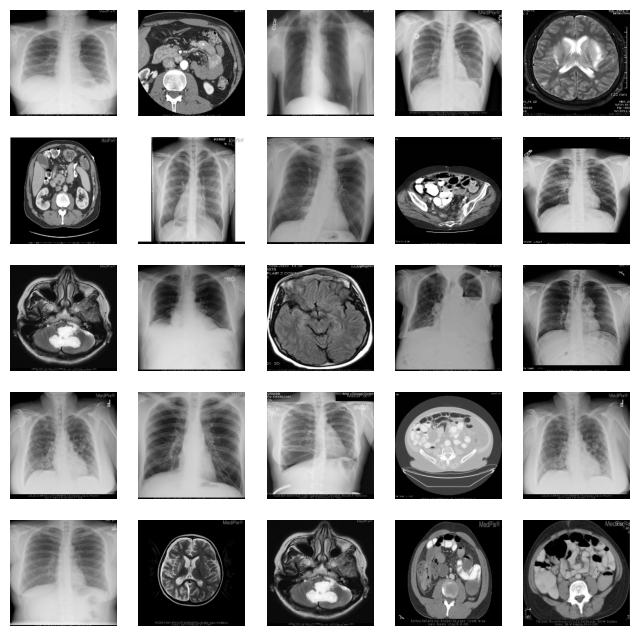

In [144]:
fig, ax = plt.subplots(5,5, figsize = (8, 8))

for i in range(5):
    ax[i][0].imshow(images[i])
    ax[i][0].axis('off')
    ax[i][1].imshow(images[i+5])
    ax[i][1].axis('off')
    ax[i][2].imshow(images[i+10])
    ax[i][2].axis('off')
    ax[i][3].imshow(images[i+15])
    ax[i][3].axis('off')
    ax[i][4].imshow(images[i+20])
    ax[i][4].axis('off')

## **Vocab Size = 820**

In [145]:
# Model training and evaluation
vocab_size = sequences.max() + 1
print(vocab_size)

820


## **Pre - trained Models (VGG 16, ResNet50) with Bi LSTM**

In [146]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Input, Flatten, LSTM, Embedding, Dense, Concatenate, Bidirectional, Dropout

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_11[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

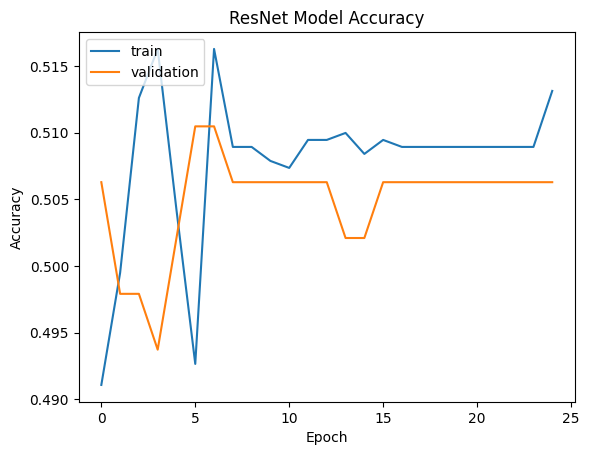

8/8 [==============================] - 7s 681ms/step
ResNet Model Evaluation Metrics
Accuracy: 0.5063
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_12[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 11

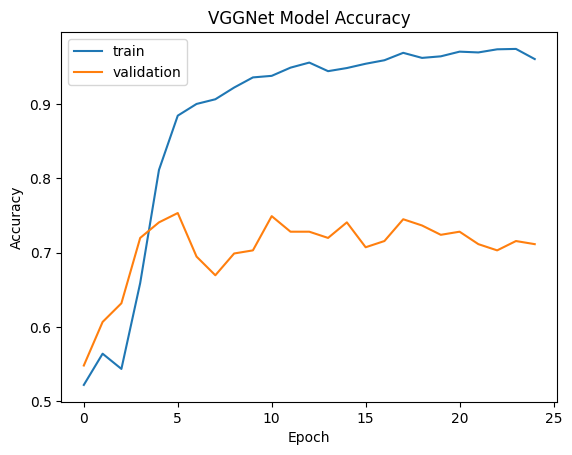

8/8 [==============================] - 10s 1s/step
VGGNet Model Evaluation Metrics
Accuracy: 0.6109
Precision: 0.5984
Recall: 0.6441
F1-score: 0.6204


In [147]:
# Load pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

models = [resnet_model, vgg_model]
model_names = ['ResNet', 'VGGNet']

for i, model in enumerate(models):
    for layer in model.layers:
        layer.trainable = False

    image_input = model.input
    image_branch = Flatten()(model.output)

    text_input = Input(shape=(10,), name='text_input')
    text_branch = Embedding(input_dim=vocab_size, output_dim=64)(text_input)
    text_branch = Bidirectional(LSTM(64, return_sequences=False))(text_branch)
    text_branch = Dropout(0.5)(text_branch)

    combined = Concatenate()([image_branch, text_branch])
    combined = Dropout(0.4)(combined)
    combined = Dense(512, activation="relu")(combined)
    combined = Dropout(0.3)(combined)
    combined = Dense(256, activation="relu")(combined)
    combined = Dropout(0.3)(combined)
    combined = Dense(128, activation="relu")(combined)


    output = Dense(1, activation='sigmoid')(combined)

    combined_model = tf.keras.Model(inputs=[image_input, text_input], outputs=output)
    combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Print model summary
    combined_model.summary()

    print(f"Training {model_names[i]} model")
    history = combined_model.fit(
        train_data, 
        epochs=25, batch_size=32, 
        validation_data=val_data,
        callbacks=[tf.keras.callbacks.ModelCheckpoint(f'best_{model_names[i]}.h5', verbose=1, save_best_only=True, monitor='val_accuracy')]
    )

    print(f"Results for {model_names[i]} model")
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_names[i]} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Evaluate model on validation data
    val_predictions = combined_model.predict(val_data)
    val_predictions = np.round(val_predictions).flatten()
    val_labels = np.concatenate([y for x, y in val_data], axis=0)

    from sklearn.metrics import precision_recall_fscore_support, accuracy_score

    accuracy = accuracy_score(val_labels, val_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

    print(f"{model_names[i]} Model Evaluation Metrics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

## **CNN with Bi LSTM**

In [148]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Embedding, Dense, Concatenate, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [149]:
# Define vocabulary size
vocab_size = sequences.max() + 1
print(vocab_size)

820


In [150]:
# Define the image input
image_input = Input(shape=(224, 224, 3), name='image_input')
print(image_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input'), name='image_input', description="created by layer 'image_input'")


In [151]:
# Define the text input
text_input = Input(shape=(10,), name='text_input')
print(text_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='text_input'), name='text_input', description="created by layer 'text_input'")


In [152]:
# Image branch
image_branch = Conv2D(64, (3, 3), activation='relu', padding="same")(image_input)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.4)(image_branch)
image_branch = Conv2D(128, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.3)(image_branch)
image_branch = Conv2D(256, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.3)(image_branch)
image_branch = Flatten()(image_branch)

# Text branch
text_branch = Embedding(input_dim=vocab_size, output_dim=64)(text_input)
text_branch = Bidirectional(LSTM(64, return_sequences=False))(text_branch)
text_branch = Dropout(0.4)(text_branch)

# Combine branches
combined = Concatenate()([image_branch, text_branch])
combined = Dropout(0.4)(combined)
combined = Dense(512, activation="relu")(combined)
combined = Dense(256, activation="relu")(combined)
combined = Dense(128, activation="relu")(combined)

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Define the model
model = keras.Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [153]:
# Print model summary
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_206 (Conv2D)         (None, 224, 224, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_26 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_206[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 dropout_56 (Dropout)        (None, 112, 112, 64)         0         ['max_pooling2d_26[0][0

In [154]:
# Define the checkpoint callback
checkpointer = tf.keras.callbacks.ModelCheckpoint('kishore_code\CNN_BiLSTM.h5', 
                                                  verbose=1, save_best_only=True,
                                                  monitor='val_accuracy')

# Train the model
history = model.fit(
    train_data, 
    epochs=25, batch_size=32, 
    validation_data=val_data,
    callbacks=[checkpointer]
)

Epoch 1/25


60/60 [==============================] - ETA: 0s - loss: 0.9640 - accuracy: 0.4916
Epoch 1: val_accuracy improved from -inf to 0.61925, saving model to kishore_code\CNN_BiLSTM.h5
60/60 [==============================] - 111s 2s/step - loss: 0.9640 - accuracy: 0.4916 - val_loss: 0.6883 - val_accuracy: 0.6192
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.7198
Epoch 2: val_accuracy improved from 0.61925 to 0.70711, saving model to kishore_code\CNN_BiLSTM.h5
60/60 [==============================] - 108s 2s/step - loss: 0.5486 - accuracy: 0.7198 - val_loss: 0.5667 - val_accuracy: 0.7071
Epoch 3/25
60/60 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8421
Epoch 3: val_accuracy did not improve from 0.70711
60/60 [==============================] - 106s 2s/step - loss: 0.3447 - accuracy: 0.8421 - val_loss: 0.6483 - val_accuracy: 0.6611
Epoch 4/25
60/60 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8720

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


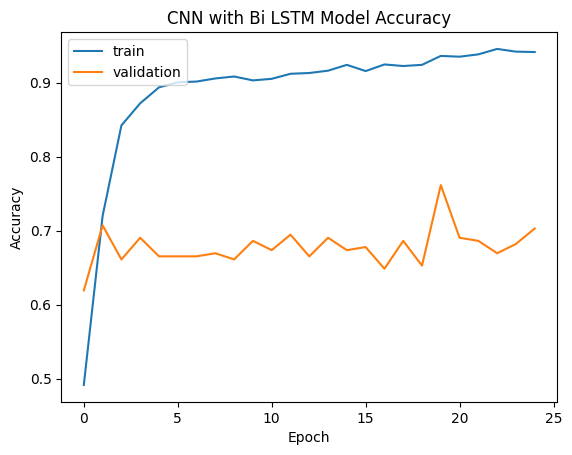

8/8 [==============================] - 3s 244ms/step
CNN with Bi LSTM Evaluation Metrics
Accuracy: 0.5356
Precision: 0.5304
Recall: 0.5169
F1-score: 0.5236


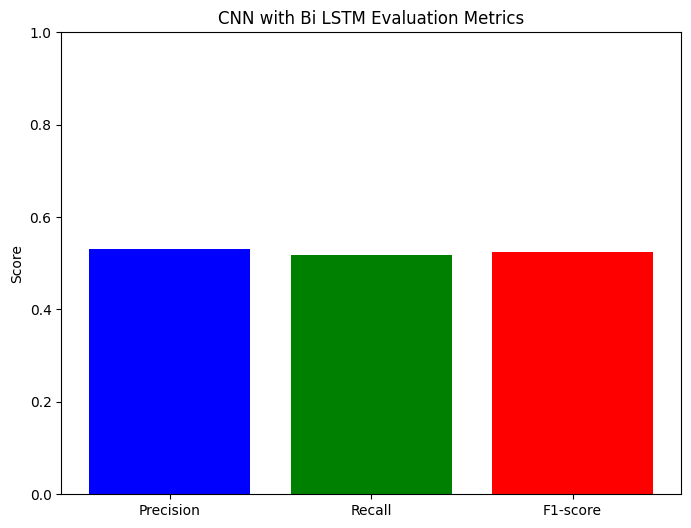

In [155]:
# Plot "Accuracy"
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN with Bi LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate model on validation data
val_predictions = model.predict(val_data)
val_predictions = np.round(val_predictions).flatten()
val_labels = np.concatenate([y for x, y in val_data], axis=0)

accuracy = accuracy_score(val_labels, val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

print("CNN with Bi LSTM Evaluation Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot precision, recall, and F1-score
metrics = {'Precision': precision, 'Recall': recall, 'F1-score': f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
plt.title('CNN with Bi LSTM Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

## **CNN with Bi LSTM & Multi Head Self Attention**

In [156]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Embedding, Dense, Concatenate, Bidirectional, Dropout, LayerNormalization
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Define the vocabulary size
vocab_size = sequences.max() + 1

# Define MultiHeadSelfAttention layer
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        if embed_dim % self.num_heads != 0:
            raise ValueError(f"embed_dim must be divisible by num_heads. Got embed_dim={embed_dim} and num_heads={num_heads}.")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

# Define the image input
image_input = Input(shape=(224, 224, 3), name='image_input')

# Define the text input
text_input = Input(shape=(10,), name='text_input')

# Image branch
image_branch = Conv2D(64, (3, 3), activation='relu', padding="same")(image_input)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.4)(image_branch)
image_branch = Conv2D(128, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.3)(image_branch)
image_branch = Conv2D(256, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.3)(image_branch)
image_branch = Flatten()(image_branch)

# Text branch
text_branch = Embedding(input_dim=vocab_size, output_dim=64)(text_input)
text_branch = Bidirectional(LSTM(64, return_sequences=False))(text_branch)
text_branch = MultiHeadSelfAttention(embed_dim=128, num_heads=8)(text_branch)
text_branch = Bidirectional(LSTM(64, return_sequences=False))(text_branch)
text_branch = Dropout(0.4)(text_branch)

# Combine branches
combined = Concatenate()([image_branch, text_branch])
combined = Dropout(0.4)(combined)
combined = Dense(512, activation="relu")(combined)
combined = Dense(256, activation="relu")(combined)
combined = Dense(128, activation="relu")(combined)

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Define the model
model2 = keras.Model(inputs=[image_input, text_input], outputs=output)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [157]:
# Print model summary
model2.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_209 (Conv2D)         (None, 224, 224, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_29 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_209[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 dropout_61 (Dropout)        (None, 112, 112, 64)         0         ['max_pooling2d_29[0][0

In [158]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('kishore_code\CNN_BiLSTM_MHAM.h5', 
                                                  verbose=1, save_best_only = True,
                                                monitor='val_accuracy')

history2 = model2.fit(
    train_data, 
    epochs=25, batch_size=32, 
    validation_data = val_data,
    callbacks = checkpointer
         )

Epoch 1/25
60/60 [==============================] - ETA: 0s - loss: 0.8764 - accuracy: 0.5184
Epoch 1: val_accuracy improved from -inf to 0.58996, saving model to kishore_code\CNN_BiLSTM_MHAM.h5
60/60 [==============================] - 117s 2s/step - loss: 0.8764 - accuracy: 0.5184 - val_loss: 0.6900 - val_accuracy: 0.5900
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.7392
Epoch 2: val_accuracy improved from 0.58996 to 0.64854, saving model to kishore_code\CNN_BiLSTM_MHAM.h5
60/60 [==============================] - 108s 2s/step - loss: 0.5430 - accuracy: 0.7392 - val_loss: 0.7553 - val_accuracy: 0.6485
Epoch 3/25
60/60 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.8368
Epoch 3: val_accuracy improved from 0.64854 to 0.71967, saving model to kishore_code\CNN_BiLSTM_MHAM.h5
60/60 [==============================] - 109s 2s/step - loss: 0.3872 - accuracy: 0.8368 - val_loss: 0.6607 - val_accuracy: 0.7197
Epoch 4/25
60/60 [=

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


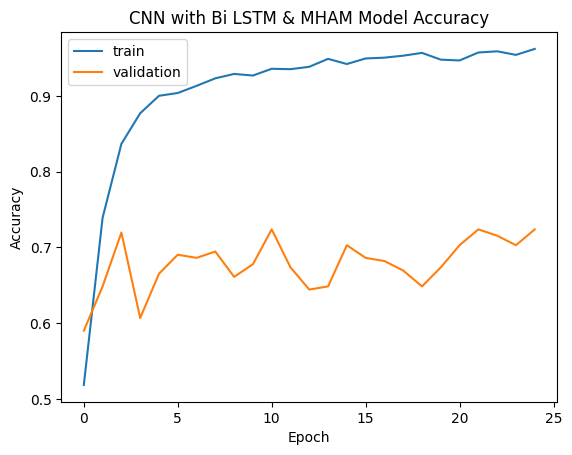

8/8 [==============================] - 3s 249ms/step
CNN with Bi LSTM & MHAM Evaluation Metrics
Accuracy: 0.5481
Precision: 0.5431
Recall: 0.5339
F1-score: 0.5385


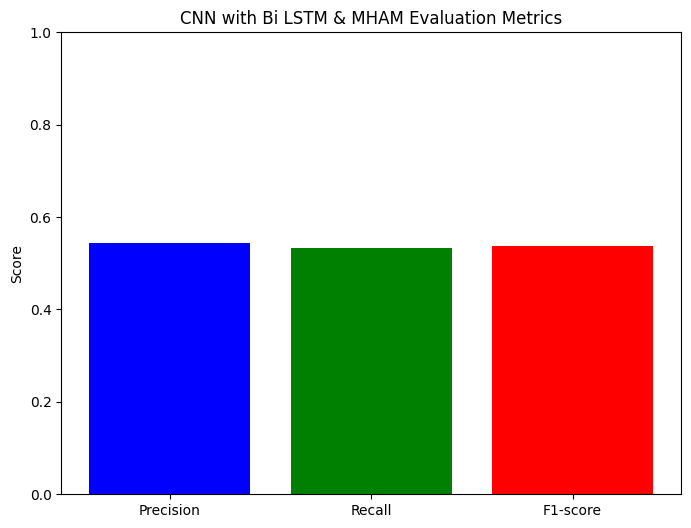

In [159]:
print(history2.history.keys())
#  "Accuracy"
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('CNN with Bi LSTM & MHAM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate model on validation data
val_predictions = model2.predict(val_data)
val_predictions = np.round(val_predictions).flatten()
val_labels = np.concatenate([y for x, y in val_data], axis=0)

accuracy = accuracy_score(val_labels, val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

print("CNN with Bi LSTM & MHAM Evaluation Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot precision, recall, and F1-score
metrics = {'Precision': precision, 'Recall': recall, 'F1-score': f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
plt.title('CNN with Bi LSTM & MHAM Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

## **CNN with LSTM & Self Attention**

In [160]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Embedding, Dense, Concatenate, Dropout, Attention
from tensorflow.keras.models import Model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Define vocabulary size
vocab_size = sequences.max() + 1

# Define image input
image_input = Input(shape=(224, 224, 3), name='image_input')

# Define text input
text_input = Input(shape=(10,), name='text_input')

# Image branch
image_branch = Conv2D(64, (3, 3), activation='relu', padding="same")(image_input)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.4)(image_branch)
image_branch = Conv2D(128, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.3)(image_branch)
image_branch = Conv2D(256, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.3)(image_branch)
image_branch = Flatten()(image_branch)

# Text branch
text_branch = Embedding(input_dim=vocab_size, output_dim=64)(text_input)
text_branch = LSTM(64, return_sequences=True)(text_branch)

# Add Attention layer after LSTM
context_vector = Attention()([text_branch, text_branch])  # Apply self-attention
context_vector = Flatten()(context_vector)

# Combine branches
combined = Concatenate()([image_branch, context_vector])
combined = Dropout(0.4)(combined)
combined = Dense(512, activation="relu")(combined)
combined = Dense(256, activation="relu")(combined)
combined = Dense(128, activation="relu")(combined)

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Define the model
model3 = Model(inputs=[image_input, text_input], outputs=output)
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [161]:
# Print model summary
model3.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_212 (Conv2D)         (None, 224, 224, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_32 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_212[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 dropout_66 (Dropout)        (None, 112, 112, 64)         0         ['max_pooling2d_32[0][0

In [162]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('kishore_code\CNN_LSTM_SAM.h5', 
                                                  verbose=1, save_best_only = True,
                                                monitor='val_accuracy')

history3 = model3.fit(
    train_data, 
    epochs=25, batch_size=32, 
    validation_data = val_data,
    callbacks = checkpointer
         )

Epoch 1/25
60/60 [==============================] - ETA: 0s - loss: 0.8890 - accuracy: 0.5808
Epoch 1: val_accuracy improved from -inf to 0.74477, saving model to kishore_code\CNN_LSTM_SAM.h5
60/60 [==============================] - 112s 2s/step - loss: 0.8890 - accuracy: 0.5808 - val_loss: 0.5582 - val_accuracy: 0.7448
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 0.4323 - accuracy: 0.7959
Epoch 2: val_accuracy did not improve from 0.74477
60/60 [==============================] - 107s 2s/step - loss: 0.4323 - accuracy: 0.7959 - val_loss: 0.6630 - val_accuracy: 0.6527
Epoch 3/25
60/60 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8673
Epoch 3: val_accuracy did not improve from 0.74477
60/60 [==============================] - 106s 2s/step - loss: 0.3038 - accuracy: 0.8673 - val_loss: 0.6470 - val_accuracy: 0.7029
Epoch 4/25
60/60 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8851
Epoch 4: val_accuracy did not impr

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


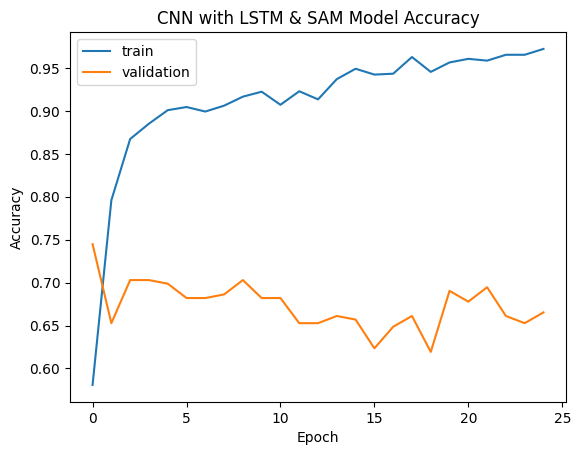

In [163]:
# Plot accuracy
print(history3.history.keys())
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('CNN with LSTM & SAM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

8/8 [==============================] - 2s 245ms/step
CNN with LSTM & SAM Evaluation Metrics
Accuracy: 0.5146
Precision: 0.5089
Recall: 0.4831
F1-score: 0.4957


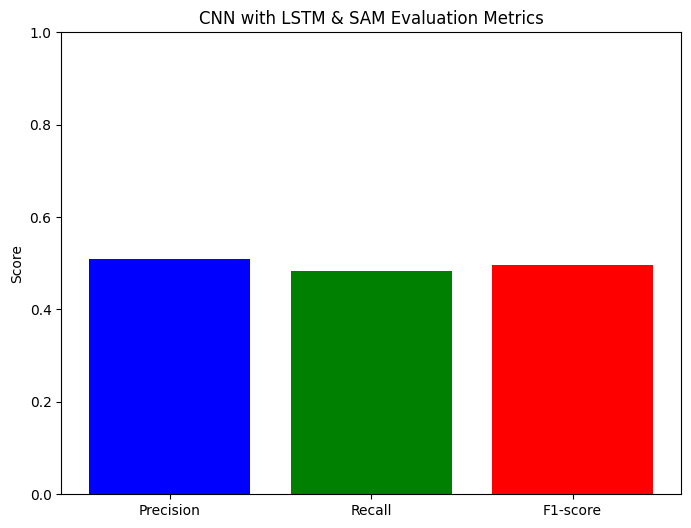

In [164]:
# Evaluate model on validation data
val_predictions = model3.predict(val_data)
val_predictions = np.round(val_predictions).flatten()
val_labels = np.concatenate([y for x, y in val_data], axis=0)

accuracy = accuracy_score(val_labels, val_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

print("CNN with LSTM & SAM Evaluation Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot precision, recall, and F1-score
metrics = {'Precision': precision, 'Recall': recall, 'F1-score': f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
plt.title('CNN with LSTM & SAM Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [165]:
# After training your model

# Assuming you have a validation dataset 'val_data'  
import numpy as np
from PIL import Image

# Helper function to decode text sequences
def decode_sequence(sequence):
    return ' '.join(tokenizer.index_word.get(idx, '<unk>') for idx in sequence)

for sample, labs in val_data.take(100):
    images, seqs = sample
    question = decode_sequence(seqs[0].numpy())
    print("Question: ", question)

    # forward pass
    outputs = model.predict([images, seqs])
    print("Predicted Answer: ", "Yes" if outputs[0][0] >= 0.5 else "No")
    print("Actual Answer: ", "Yes" if labs[0] == 1 else "No")

Question:  does the gallbladder appear distended <unk> <unk> <unk> <unk> <unk>
1/1 [==============================] - 1s 798ms/step
Predicted Answer:  No
Actual Answer:  Yes
Question:  does this image show midline shift <unk> <unk> <unk> <unk>
1/1 [==============================] - 0s 284ms/step
Predicted Answer:  Yes
Actual Answer:  Yes
Question:  is the left renal cyst uniform <unk> <unk> <unk> <unk>
1/1 [==============================] - 0s 275ms/step
Predicted Answer:  Yes
Actual Answer:  Yes
Question:  is there air present under the diaphragm <unk> <unk> <unk>
1/1 [==============================] - 1s 622ms/step
Predicted Answer:  No
Actual Answer:  No
Question:  is there a fracture of the skull <unk> <unk> <unk>
1/1 [==============================] - 0s 279ms/step
Predicted Answer:  No
Actual Answer:  No
Question:  is bowel distension present <unk> <unk> <unk> <unk> <unk> <unk>
1/1 [==============================] - 0s 278ms/step
Predicted Answer:  Yes
Actual Answer:  No
Question